In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users.

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301],
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479],
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2024-07-11 16:54:51--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  87.0MB/s    in 0.3s    

2024-07-11 16:54:52 (87.0 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [4]:
df = df_books.merge(df_ratings, on='isbn', how='right')

In [5]:
df

,isbn,title,author,user,rating
0,034545104X,Flesh Tones: A Novel,M. J. Rose,276725,0.0
1,0155061224,Rites of Passage,Judith Rae,276726,5.0
2,0446520802,The Notebook,Nicholas Sparks,276727,0.0
3,052165615X,Help!: Level 1,Philip Prowse,276729,3.0
4,0521795028,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,276729,6.0
...,...,...,...,...,...
1149775,1563526298,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,276704,9.0
1149776,0679447156,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,276706,0.0
1149777,0515107662,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,276709,10.0
1149778,0590442449,Fourth Grade Rats,Jerry Spinelli,276721,10.0


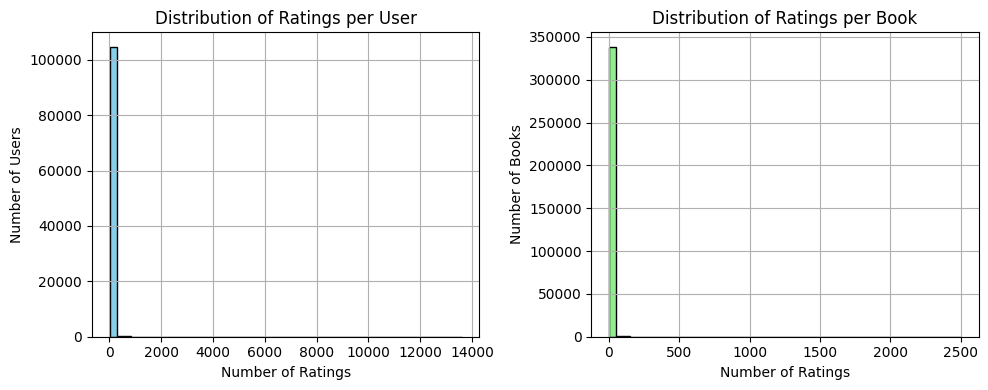

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(df['user'].value_counts(), bins=50, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Ratings per User')
axs[0].set_xlabel('Number of Ratings')
axs[0].set_ylabel('Number of Users')
axs[0].grid(True)

axs[1].hist(df['isbn'].value_counts(), bins=50, color='lightgreen', edgecolor='black')
axs[1].set_title('Distribution of Ratings per Book')
axs[1].set_xlabel('Number of Ratings')
axs[1].set_ylabel('Number of Books')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [7]:
user_filter = df['user'].value_counts() >= 200
rating_filter = df['isbn'].value_counts() >= 100

df = df[(df['user'].isin(user_filter[user_filter].index)) & (df['isbn'].isin(rating_filter[rating_filter].index))]

In [8]:
df

,isbn,title,author,user,rating
1456,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,277427,10.0
1469,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,277427,0.0
1471,0060934417,Bel Canto: A Novel,Ann Patchett,277427,0.0
1474,0061009059,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,277427,9.0
1484,0140067477,The Tao of Pooh,Benjamin Hoff,277427,0.0
...,...,...,...,...,...
1147304,0804111359,Secret History,DONNA TARTT,275970,0.0
1147436,140003065X,A Fine Balance,Rohinton Mistry,275970,0.0
1147439,1400031346,The No. 1 Ladies' Detective Agency,Alexander McCall Smith,275970,0.0
1147440,1400031354,Tears of the Giraffe (No.1 Ladies Detective Ag...,Alexander McCall Smith,275970,0.0


In [9]:
mat = df.pivot_table(index='title', columns='user', values='rating').fillna(0)
sparse_mat = csr_matrix(mat)

knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(sparse_mat)

NearestNeighbors(algorithm='brute', metric='cosine')

In [10]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  dists, books = knn.kneighbors([mat.loc[book]], 6, return_distance=True)

  recommended_books = [book,[]]
  for i in range(5,0,-1):
    recommended_books[1].append([mat.iloc[books[0][i]].name,dists[0][i]])

  return recommended_books

In [11]:
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]

In [12]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
